# Parameter

In [1]:
# save data in this folder: train or eval on uniform distr. data
uni = 'train' #or 'eval'

# train and apply boots: True/False
load_nn = True
load_dsea = True

In [59]:
# DSEA Params
one_model = True
Nit = 16
Nep = 60

In [60]:
# Variables: Label
# drop out all events with Energies outside the range
lower_limit = 100
upper_limit = 10**5

# Variables: NN
num_bins = 10 # number of bins (energy classes), output_shape

# variables for bootstrap (NN and DSEA)
npulls = 200

In [61]:
if uni is 'train':
    folder_save = 'uni_train'
    print(folder_save)
elif uni is 'eval':
    folder_save = 'uni_eval'
    print(folder_save)
else:
    print('INVALID ENTRY!')

uni_train


# Imports and Numpy Setup

In [5]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys

sys.path.insert(0,'/net/nfshome/home/shaefs/CherenkovDeconvolution.py')

In [6]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn import utils

import cherenkovdeconvolution as cd
import cherenkovdeconvolution.stepsize as stepsize

# Read in data

In [7]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']
#feature_list = ['MCPrimary.energy']



In [8]:
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

In [9]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)
df_raw

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [10]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

# Discretize the target Neutrino Energy

In [11]:
# discretize
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

In [12]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<upper_limit) & (df['MCPrimary.energy']>lower_limit)]
df

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [13]:
## log-scaled Binning
bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [14]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [15]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [16]:
y = df['E_discr'].to_numpy()
y.shape

(13262094,)

In [17]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [18]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.1, subset=None)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(11935884, 12) (11935884,) (1326210, 12) (1326210,)


In [19]:
X_train.shape

(11935884, 12)

In [20]:
y_train_uni = np.zeros(num_bins*50_000, dtype=int)
X_train_uni = np.zeros((num_bins*50_000, len(feature_list)))

for i in range(10):
    X_train_uni[i*50_000:(i+1)*50_000] = X_train[y_train==i][0:50_000]
    y_train_uni[i*50_000:(i+1)*50_000] = y_train[y_train==i][0:50_000]

X_train_uni[-1], y_train_uni[-1]

(array([5.90000000e+01, 1.15818700e-02, 4.83849300e-05, 1.51278222e-01,
        2.10000000e-01, 8.06525134e+04, 1.10000000e+02, 1.02564103e-01,
        6.30000000e+01, 1.15521034e-01, 5.24663952e+02, 4.45074299e+01]), 9)

In [21]:
# reduce size of evaluation data
sample_size=500_000

In [22]:
# reduce size of test set
y_eval = y_eval[0:sample_size]
X_eval = X_eval[0:sample_size]
X_eval.shape, y_eval.shape

((500000, 12), (500000,))

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_uni)
X_train_uni = scaler.transform(X_train_uni)
X_eval = scaler.fit_transform(X_eval)
#X_eval = scaler.transform(X_eval)

In [24]:
if uni is 'eval':
    # y_eval is now uniform distributed
    X_eval, X_train_uni = X_train_uni, X_eval
    y_eval, y_train_uni = y_train_uni, y_eval

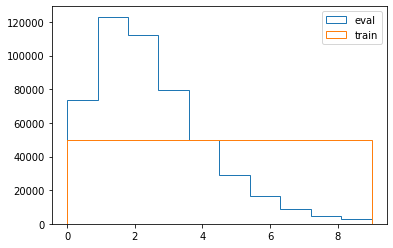

In [25]:
plt.hist(y_eval, histtype='step', label='eval')
plt.hist(y_train_uni, histtype='step', label='train')
plt.legend()
plt.show()

# True distribution

In [26]:
_, f_true_eval = np.unique(y_eval, return_counts=True)
f_true_eval = f_true_eval/len(y_eval)
f_true_eval

array([0.147122, 0.246214, 0.224416, 0.15894 , 0.099776, 0.057786,
       0.032582, 0.018136, 0.00985 , 0.005178])

In [27]:
_, f_true_train = np.unique(y_train_uni, return_counts=True)
f_true_train = f_true_train/len(y_train_uni)
f_true_train

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Build Neural Network

In [28]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Define Classifier (Wrapper for nn/Sklearn)

In [29]:
class MyClassifier():
    def __init__(self, batch_size=2048, epochs=5, learning_rate=0.0005, one_model=False):
        """
        one_model: If True dsea will train only one model instead of generating a new one in each dsea iteration
        batchsize, epoch, learning_rate: model parameters
        """
        self.Niter = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = None
        self.one_model = one_model
        self.history = [] # save model_history for each dsea iteration

    def fit(self, X, y, sample_weight=None):
        # print iteration num
        self.Niter += 1
        print(f'\nNumber iteration: {self.Niter}')

        """
        y is NOT one-hot encoded yet
        """
        y_hot = np.zeros((y.size, y.max()+1))
        y_hot[np.arange(y.size),y] = 1
        
        # create new model if (one_model=False) or (one_model = True and there exist no model yet)
        if self.model is None or self.one_model is False:
            self.model = make_model(num_features=(len(feature_list), ), num_classes=y.max()+1, learning_rate=self.learning_rate)
        print(type(self.model))
        history = self.model.fit(X, y_hot, sample_weight=sample_weight, batch_size=self.batch_size, epochs=self.epochs)
        self.history.append(history)

        return self
    
    def predict_proba(self, X):
        return self.model.predict(X)

    def get_model(self):
        return self.model

    def get_model_history(self):
        list_loss = []
        list_acc = []
        for history in self.history:
            list_loss += history.history['loss']
            list_acc += history.history['categorical_accuracy']
            
        list_loss = np.array(list_loss)
        list_acc = np.array(list_acc)

        return list_loss, list_acc

# Neural Network: Training

In [30]:
# need one hot encoded vector for softmax
y_train_hot = np.zeros((y_train_uni.size, y_train_uni.max()+1))
y_train_hot[np.arange(y_train_uni.size),y_train_uni] = 1

y_eval_hot = np.zeros((y_eval.size, y_eval.max()+1))
y_eval_hot[np.arange(y_eval.size),y_eval] = 1

In [31]:
model = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)

if load_nn:
    model.load_weights(f'bias_results/{folder_save}/NN/model.h5')
else:
    model.fit(X_train_uni, y_train_hot, batch_size=2048, epochs=50)
    model.save_weights(f'bias_results/{folder_save}/NN/model.h5')

# Neural Network: Evaluation with Bootstrap

In [32]:
# apply boots or load in data
if load_nn:
    df_boots_nn = pd.read_csv(f'bias_results/{folder_save}/NN/bootstrap.csv')
    bootstrap_nn = df_boots_nn.to_numpy()
    print('Read in bootstrap results.')
else:
    bootstrap_nn = np.ndarray(shape=(npulls,num_bins),dtype=float)

    for i in range(npulls):
        if i%1 ==0:
            print(i+1,' of ', npulls)
        
        # create random subsample of the evaluation data
        X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=sample_size, random_state=i)# bootstrap random sample from X_test

        # predict subsample
        y_pred_temp = model.predict(X_eval_bst)

        # save f_pred for each evaluation subsample
        bootstrap_nn[i,:] = y_pred_temp.sum(axis=0)
        
    df_boots_nn = pd.DataFrame(bootstrap_nn)
    df_boots_nn.to_csv(f'bias_results/{folder_save}/NN/bootstrap.csv', index=False)

Read in bootstrap results.


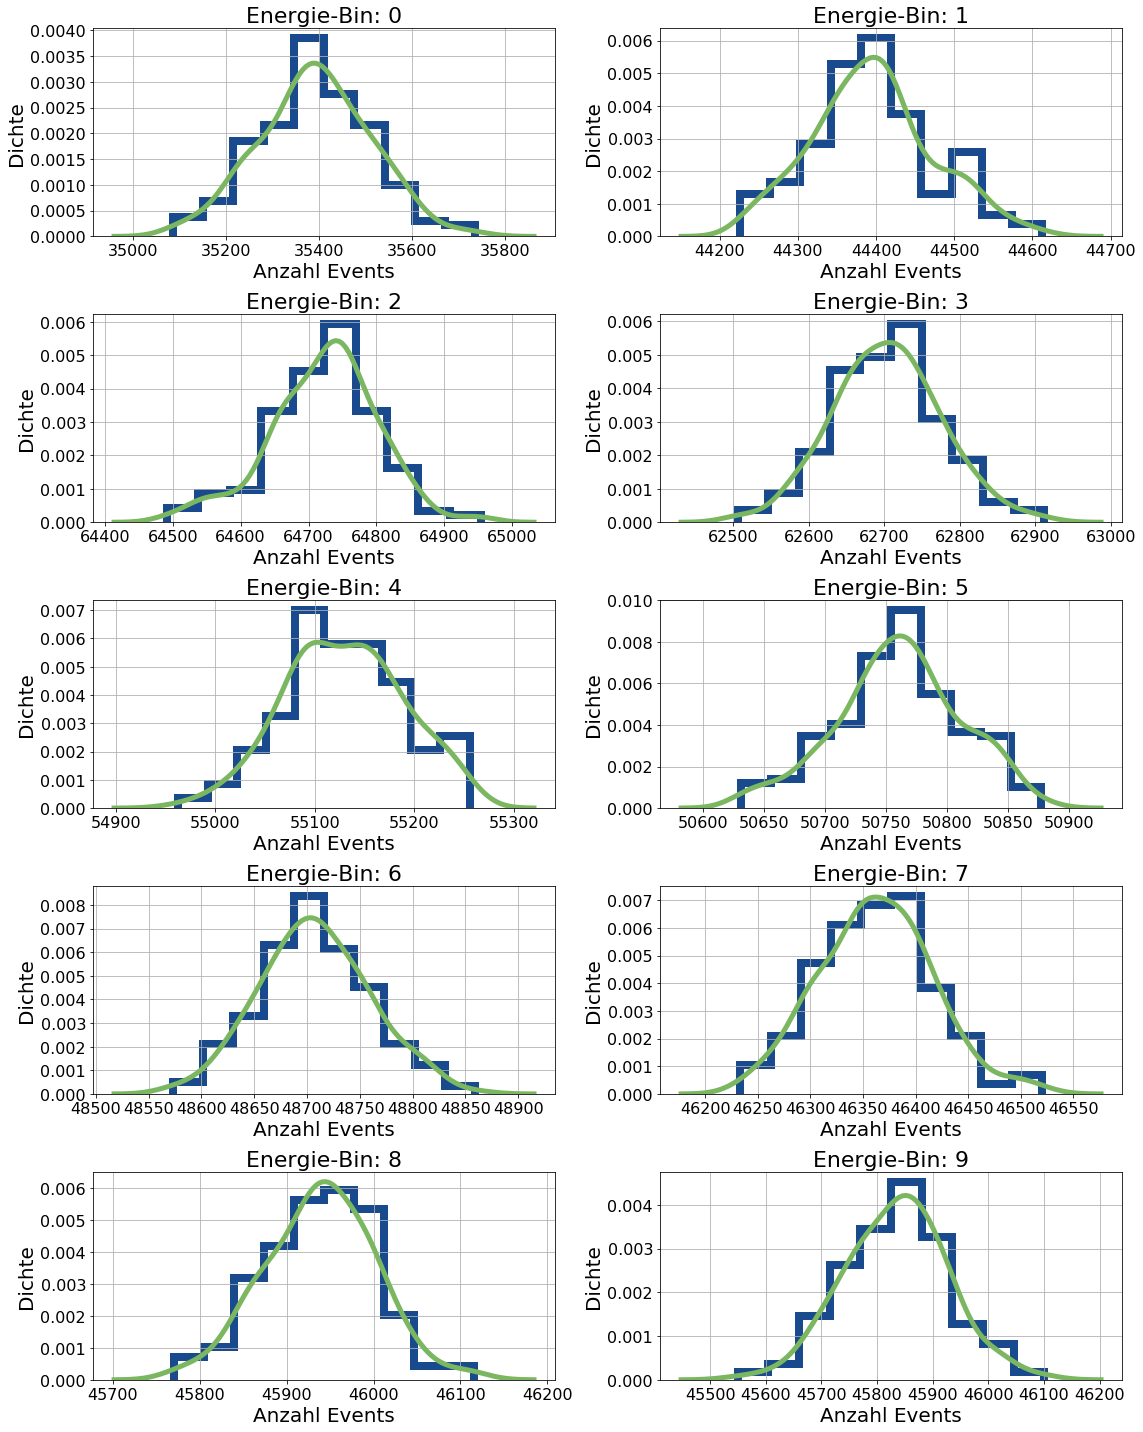

In [33]:
fig, axs = plt.subplots(5,2, figsize=(16,20))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_nn[:,2*i+j], ax=axs[i,j], bins=10, kde=True, norm_hist=True, kde_kws={'linewidth': 5, 'color': '#7bb661'}, hist_kws={'color': '#194a8d', 'histtype': 'step', 'linewidth': 8, 'alpha': 1})
        axs[i,j].set_xlabel('Anzahl Events', fontsize=20)#df1c44
        axs[i,j].set_ylabel('Dichte', fontsize=20)
        axs[i,j].set_title(f'Energie-Bin: {2*i+j}', fontsize=22)
        plt.setp(axs[i,j].get_xticklabels(), fontsize=16)
        plt.setp(axs[i,j].get_yticklabels(), fontsize=16)
        axs[i,j].grid()

plt.tight_layout()
plt.savefig(f'bias_results/{folder_save}/NN/bootstrap.pdf')
plt.show()

In [34]:
boots_mean = bootstrap_nn.mean(axis=0)
boots_mean_norm = boots_mean/boots_mean.sum()
boots_mean_norm

array([0.07079108, 0.08880064, 0.12945977, 0.12541975, 0.110271  ,
       0.10153144, 0.09742587, 0.09273497, 0.09188732, 0.09167818])

In [35]:
boots_std = bootstrap_nn.std(axis=0)
boots_std_norm = boots_std/boots_mean.sum()
boots_std_norm

array([0.00023947, 0.00015474, 0.00015869, 0.00014292, 0.00011884,
       0.00010163, 0.00010438, 0.00010738, 0.00012569, 0.00018422])

In [36]:
boots_median = np.median(bootstrap_nn, axis=0)
boots_median_norm = boots_median/boots_median.sum()
boots_median_norm

array([0.07079603, 0.08879435, 0.12946951, 0.12541634, 0.11026723,
       0.10153228, 0.09742116, 0.09272873, 0.09188755, 0.09168682])

In [37]:
quantile_16 = np.quantile(bootstrap_nn, 0.16, axis=0)
quantile_16_norm = quantile_16/boots_median.sum()
quantile_16_norm

array([0.0705258 , 0.08863681, 0.12931389, 0.12527809, 0.11015194,
       0.10142677, 0.09732268, 0.09261468, 0.0917471 , 0.09149246])

In [38]:
quantile_84 = np.quantile(bootstrap_nn, 0.84, axis=0)
quantile_84_norm = quantile_84/boots_median.sum()
quantile_84_norm

array([0.07103589, 0.08895962, 0.12961578, 0.12555559, 0.11039348,
       0.10163576, 0.09752371, 0.09283369, 0.09200132, 0.09184791])

In [39]:
boots_mean/boots_median

array([0.99989437, 1.0000352 , 0.99988917, 0.99999159, 0.99999858,
       0.99995607, 1.00001265, 1.00003164, 0.99996187, 0.99987019])

# Plot spectrum

In [40]:
f_dsea = boots_median_norm

In [41]:
f_err = np.stack([f_dsea-quantile_16_norm, quantile_84_norm-f_dsea])
f_err

array([[2.70229356e-04, 1.57542444e-04, 1.55621838e-04, 1.38247479e-04,
        1.15289598e-04, 1.05512028e-04, 9.84873101e-05, 1.14055760e-04,
        1.40450917e-04, 1.94352403e-04],
       [2.39859386e-04, 1.65272993e-04, 1.46274299e-04, 1.39250675e-04,
        1.26254752e-04, 1.03482509e-04, 1.02545098e-04, 1.04961051e-04,
        1.13764333e-04, 1.61094727e-04]])

In [42]:
bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(num_bins)])
bin_width = np.array([bins[i+1]-bins[i] for i in range(num_bins)])

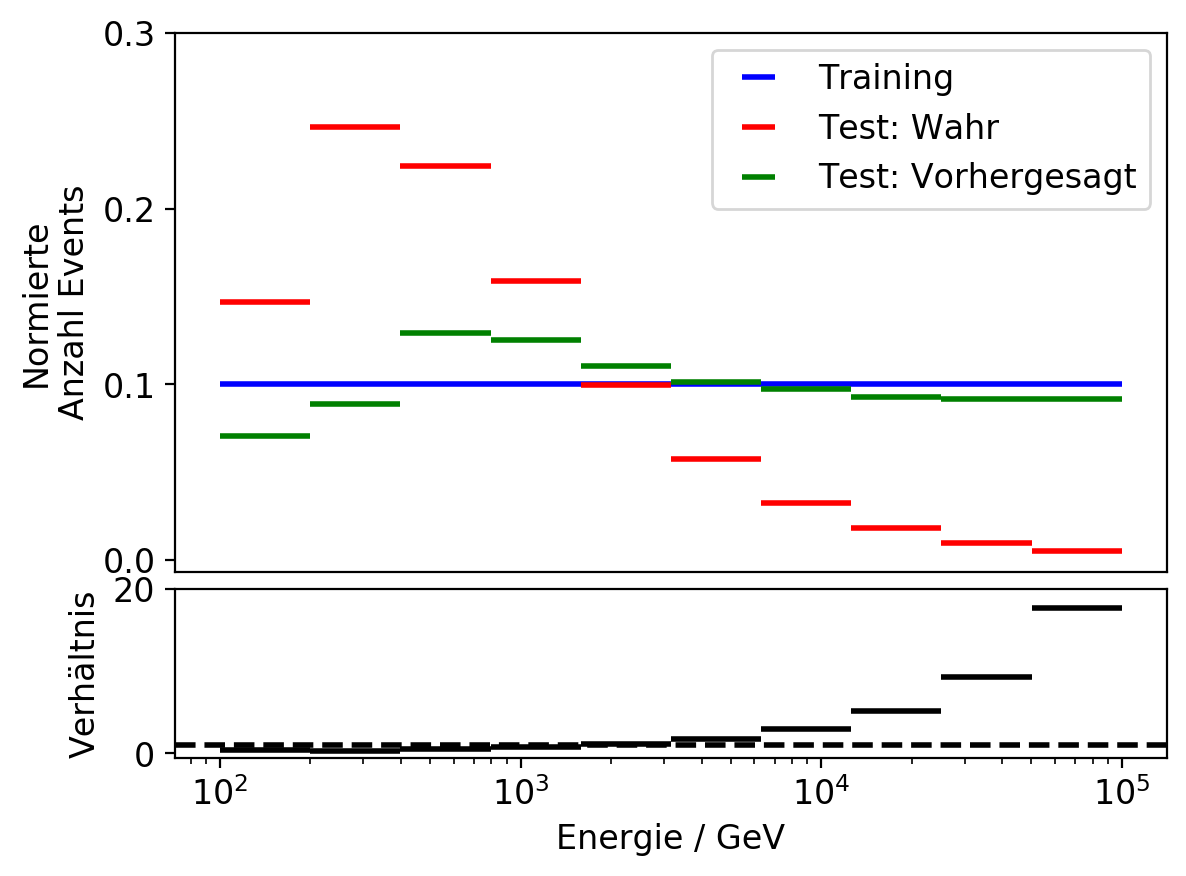

In [43]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .1) #0.001

# spectrum
axes1.errorbar(bin_centers, f_true_train, fmt=' ', color='blue', xerr=bin_width/2, elinewidth=2, label='Training') #true distr
axes1.errorbar(bin_centers, f_true_eval, fmt=' ', color='red', xerr=bin_width/2, elinewidth=2, label='Test: Wahr') #true distr
axes1.errorbar(bin_centers, f_dsea, fmt=' ', color='green', xerr=bin_width/2, yerr=None, elinewidth=2, label='Test: Vorhergesagt') #pred. distr

axes1.set_xscale('log')
axes1.set_xticks([],[])
axes1.set_yticks([0.0, 0.1, 0.2, 0.3])
axes1.set_ylabel('Normierte\nAnzahl Events', fontsize=12)
plt.setp(axes1.get_xticklabels(), fontsize=12)
plt.setp(axes1.get_yticklabels(), fontsize=12)

# ratio
axes2.errorbar(bin_centers, (f_dsea)/f_true_eval, fmt=' ', color='black', xerr=bin_width/2, yerr=None, elinewidth=2)
axes2.axhline(1, color='k', linestyle='--', linewidth=2)
axes2.set_xscale('log')
axes2.set_xlabel(r'Energie / GeV', fontsize=12)
axes2.set_yticks([0,20])
axes2.set_ylabel('Verhältnis', fontsize=12)
plt.setp(axes2.get_xticklabels(), fontsize=12)
plt.setp(axes2.get_yticklabels(), fontsize=12)

# disable xticks in top plot
axes1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes1.legend(fontsize=12)

plt.savefig(f'bias_results/uni_train/NN/spectrum.pdf', dpi=300)
plt.show()

---
# DSEA: Training

In [62]:
if load_dsea:
    model_dsea = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)
    model_dsea.load_weights(f'bias_results/{folder_save}/DSEA/model_{Nit}it_{Nep}ep_{one_model}.h5')

else:
    cf = MyClassifier(batch_size=2048, epochs=Nep, learning_rate=0.0005, one_model=one_model)

    f_est = cd.dsea(X_eval, X_train_uni, y_train_uni, cf, K=Nit) #, inspect = inspect_alpha,  alpha = alpha_exp
    model_dsea = cf.get_model()
    model_dsea.save_weights(f'bias_results/{folder_save}/DSEA/model_{Nit}it_{Nep}ep_{one_model}.h5')
    list_loss, list_acc = cf.get_model_history()


In [63]:
def plot_history(data, labely='y'):
    plt.figure(figsize=(4,3), dpi=100)
    plt.plot(data)
    plt.ylabel(labely)
    plt.xlabel('Anzahl Epochen')
    plt.legend(['training'])
    plt.tight_layout()
    plt.show()
    return

In [64]:
if not load_dsea:
    plot_history(list_loss, 'loss')
    plot_history(list_acc, 'acc')

# DSEA: Evaluation with Bootstrap

In [65]:
# apply boots or load in data
if load_dsea:
    df_boots_dsea = pd.read_csv(f'bias_results/{folder_save}/DSEA/bootstrap_{Nit}it_{Nep}ep_{one_model}.csv')
    bootstrap_dsea = df_boots_dsea.to_numpy()
    print('Read in bootstrap results.')
else:
    bootstrap_dsea = np.ndarray(shape=(npulls,num_bins),dtype=float)

    for i in range(npulls):
        if i%1 ==0:
            print(i+1,' of ', npulls)

        # create random subsample of the evaluation data
        X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=sample_size, random_state=i)# bootstrap random sample from X_test

        # predict subsample
        y_pred_temp = model_dsea.predict(X_eval_bst)

        # save f_pred for each evaluation subsample
        bootstrap_dsea[i,:] = y_pred_temp.sum(axis=0)

    df_boots_dsea = pd.DataFrame(bootstrap_dsea)
    df_boots_dsea.to_csv(f'bias_results/{folder_save}/DSEA/bootstrap_{Nit}it_{Nep}ep_{one_model}.csv', index=False)    

Read in bootstrap results.


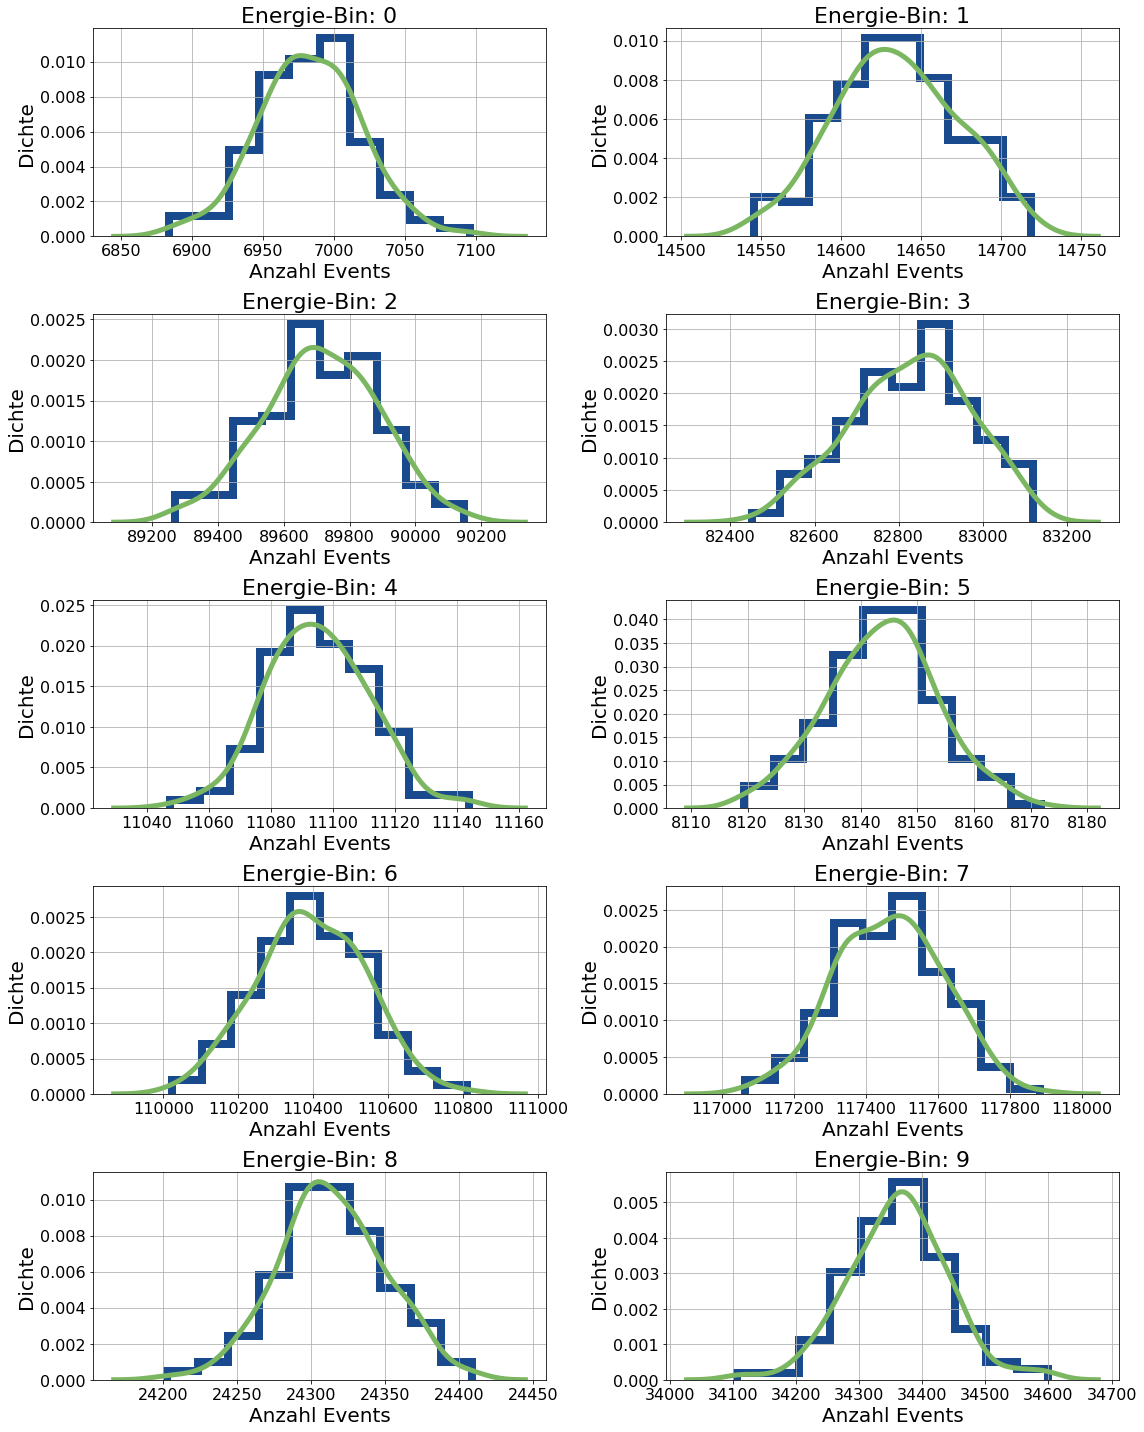

In [66]:
fig, axs = plt.subplots(5,2, figsize=(16,20))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_dsea[:,2*i+j], ax=axs[i,j], bins=10, kde=True, norm_hist=True, kde_kws={'linewidth': 5, 'color': '#7bb661'}, hist_kws={'color': '#194a8d', 'histtype': 'step', 'linewidth': 8, 'alpha': 1})
        axs[i,j].set_xlabel('Anzahl Events', fontsize=20)#df1c44
        axs[i,j].set_ylabel('Dichte', fontsize=20)
        axs[i,j].set_title(f'Energie-Bin: {2*i+j}', fontsize=22)
        plt.setp(axs[i,j].get_xticklabels(), fontsize=16)
        plt.setp(axs[i,j].get_yticklabels(), fontsize=16)
        axs[i,j].grid()

plt.tight_layout()
df_boots_nn.to_csv(f'bias_results/{folder_save}/DSEA/bootstrap_{Nit}it_{Nep}ep_{one_model}.pdf')
plt.show()

In [67]:
boots_mean = bootstrap_dsea.mean(axis=0)
boots_mean_norm = boots_mean/boots_mean.sum()
boots_mean_norm

array([0.01396813, 0.02927311, 0.17944974, 0.16567812, 0.02219308,
       0.01628979, 0.22081745, 0.23496363, 0.04863418, 0.06873278])

In [68]:
boots_std = bootstrap_dsea.std(axis=0)
boots_std_norm = boots_std/boots_mean.sum()
boots_std_norm

array([7.20278978e-05, 7.62805863e-05, 3.47435462e-04, 2.81348794e-04,
       3.28633052e-05, 1.95775941e-05, 2.86132397e-04, 2.93810466e-04,
       7.21497875e-05, 1.58633564e-04])

In [69]:
boots_median = np.median(bootstrap_dsea, axis=0)
boots_median_norm = boots_median/boots_median.sum()
boots_median_norm

array([0.01396444, 0.02927106, 0.17944254, 0.16569613, 0.02219187,
       0.01629025, 0.2208077 , 0.23496928, 0.0486284 , 0.06873832])

In [70]:
quantile_16 = np.quantile(bootstrap_dsea, 0.16, axis=0)
quantile_16_norm = quantile_16/boots_median.sum()
quantile_16_norm

array([0.01390134, 0.02919313, 0.1790779 , 0.16540635, 0.02216049,
       0.01627147, 0.2205192 , 0.23466133, 0.04856397, 0.06857856])

In [71]:
quantile_84 = np.quantile(bootstrap_dsea, 0.84, axis=0)
quantile_84_norm = quantile_84/boots_median.sum()
quantile_84_norm

array([0.01403756, 0.02936359, 0.17978558, 0.16596079, 0.02222616,
       0.01630865, 0.22110872, 0.23525925, 0.04870854, 0.0688745 ])

In [72]:
boots_mean/boots_median

array([1.00023991, 1.00004573, 1.00001586, 0.99986701, 1.00003006,
       0.99994737, 1.00001985, 0.99995165, 1.00009445, 0.99989504])

# Plot spectrum

In [73]:
f_dsea = boots_median_norm

In [74]:
f_err = np.stack([f_dsea-quantile_16_norm, quantile_84_norm-f_dsea])
f_err

array([[6.30981149e-05, 7.79370157e-05, 3.64632970e-04, 2.89786794e-04,
        3.13832584e-05, 1.87754570e-05, 2.88499781e-04, 3.07955311e-04,
        6.44321647e-05, 1.59758746e-04],
       [7.31281000e-05, 9.25253817e-05, 3.43040647e-04, 2.64658467e-04,
        3.42865394e-05, 1.83961584e-05, 3.01015502e-04, 2.89969627e-04,
        8.01372914e-05, 1.36179022e-04]])

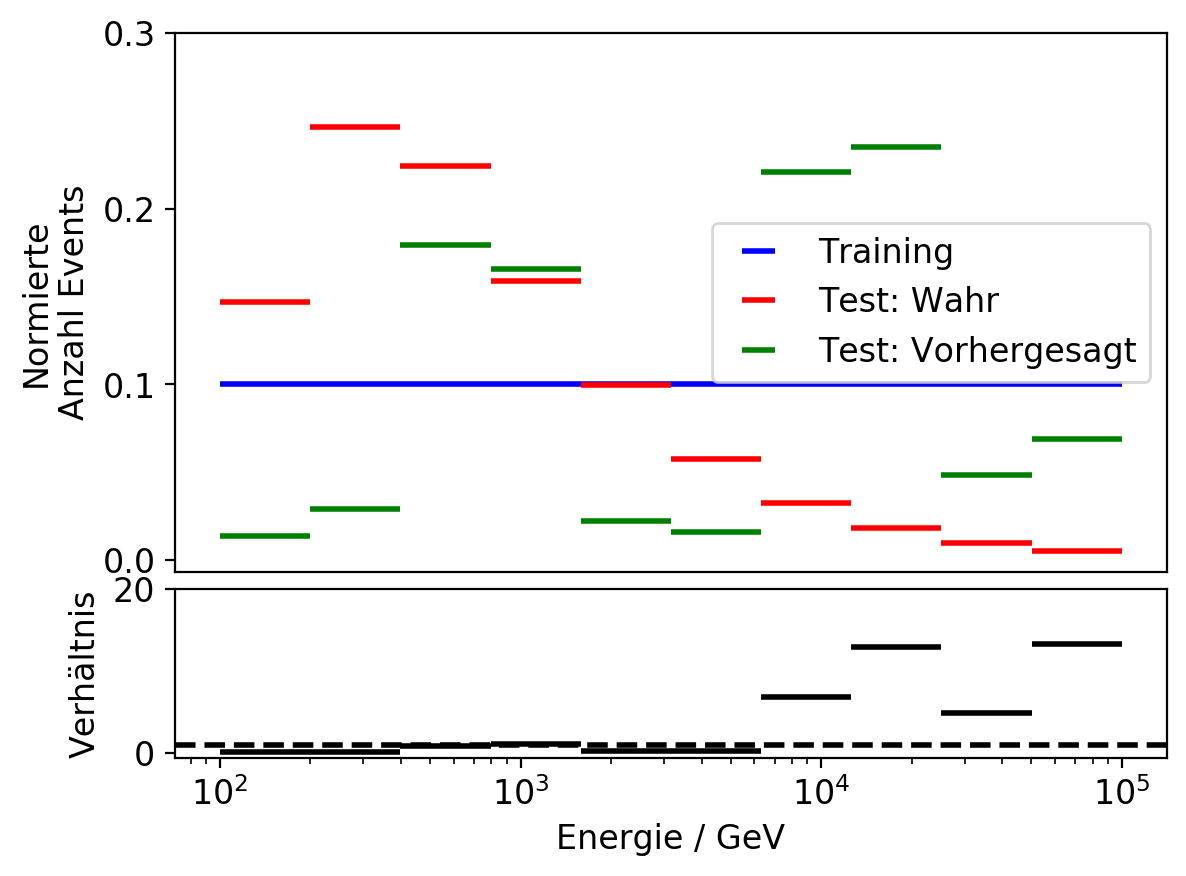

In [75]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .1) #0.001

# spectrum
axes1.errorbar(bin_centers, f_true_train, fmt=' ', color='blue', xerr=bin_width/2, elinewidth=2, label='Training') #true distr
axes1.errorbar(bin_centers, f_true_eval, fmt=' ', color='red', xerr=bin_width/2, elinewidth=2, label='Test: Wahr') #true distr
axes1.errorbar(bin_centers, f_dsea, fmt=' ', color='green', xerr=bin_width/2, yerr=None, elinewidth=2, label='Test: Vorhergesagt') #pred. distr

axes1.set_xscale('log')
axes1.set_xticks([],[])
axes1.set_yticks([0.0, 0.1, 0.2, 0.3])
axes1.set_ylabel('Normierte\nAnzahl Events', fontsize=12)
plt.setp(axes1.get_xticklabels(), fontsize=12)
plt.setp(axes1.get_yticklabels(), fontsize=12)

# ratio
axes2.errorbar(bin_centers, f_dsea/f_true_eval, fmt=' ', color='black', xerr=bin_width/2, yerr=None, elinewidth=2)
axes2.axhline(1, color='k', linestyle='--', linewidth=2)
axes2.set_xscale('log')
axes2.set_xlabel(r'Energie / GeV', fontsize=12)
axes2.set_yticks([0, 20])
axes2.set_ylabel('Verhältnis', fontsize=12)
plt.setp(axes2.get_xticklabels(), fontsize=12)
plt.setp(axes2.get_yticklabels(), fontsize=12)

# disable xticks in top plot
axes1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes1.legend(fontsize=12)

plt.savefig(f'bias_results/{folder_save}/DSEA/spectrum_{Nit}it_{Nep}ep_{one_model}.pdf', dpi=300)

plt.show()